In [66]:
'''Use multiple rounds to get a more robust results'''
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, balanced_accuracy_score, roc_auc_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
import torchvision
import shutil
import os

In [92]:
def cal_metrics(df):
    """
    calculate average accuracy, accuracy per skin type, PQD, DPM, EOM, EOpp0, EOpp1, EOdd, and NAR.
    Skin type in the input df should be in the range of [0,5].
    input val results csv path, type_indices: a list
    output a dic, 'acc_avg': value, 'acc_per_type': array[x,x,x], 'PQD', 'DPM', 'EOM'
    """
    is_binaryCLF = len(df["label"].unique()) == 2

    type_indices = sorted(list(df["fitzpatrick"].unique()))
    type_indices_binary = sorted(list(df["fitzpatrick_binary"].unique()))

    labels_array = np.zeros((len(type_indices), len(df["label"].unique())))
    correct_array = np.zeros((len(type_indices), len(df["label"].unique())))
    predictions_array = np.zeros((len(type_indices), len(df["label"].unique())))
    prob_array = [[] for i in range(len(type_indices))]
    label_array_per_fitz = [[] for i in range(len(type_indices))]

    labels_array_binary = np.zeros((2, len(df["label"].unique())))
    correct_array_binary = np.zeros((2, len(df["label"].unique())))
    predictions_array_binary = np.zeros((2, len(df["label"].unique())))

    positive_list = []  # get positive probability for binary classification
    labels_ft0 = []
    labels_ft1 = []
    predictions_ft0 = []
    predictions_ft1 = []

    for i in range(df.shape[0]):
        prediction = df.iloc[i]["prediction"]
        label = df.iloc[i]["label"]
        type = df.iloc[i]["fitzpatrick"]
        type_binary = df.iloc[i]["fitzpatrick_binary"]

        labels_array[int(type), int(label)] += 1
        predictions_array[int(type), int(prediction)] += 1
        if prediction == label:
            correct_array[int(type), int(label)] += 1

        labels_array_binary[int(type_binary), int(label)] += 1
        predictions_array_binary[int(type_binary), int(prediction)] += 1
        if prediction == label:
            correct_array_binary[int(type_binary), int(label)] += 1

        if is_binaryCLF:
            prob_array[int(type)].append(df.iloc[i]["prediction_probability"])
            label_array_per_fitz[int(type)].append(label)
            if prediction == 0:
                positive_list.append(1.0 - df.iloc[i]["prediction_probability"])
            else:
                positive_list.append(df.iloc[i]["prediction_probability"])

        if type_binary == 0:
            labels_ft0.append(label)
            predictions_ft0.append(prediction)
        else:
            labels_ft1.append(label)
            predictions_ft1.append(prediction)

    correct_array = correct_array[type_indices]
    labels_array = labels_array[type_indices]
    predictions_array = predictions_array[type_indices]

    # Accuracy, accuracy per type
    Accuracy = accuracy_score(df["label"], df["prediction"]) * 100

    acc_array = []
    for i in range(len(type_indices)):
        acc_array.append(
            accuracy_score(
                df[df["fitzpatrick"] == i]["label"],
                df[df["fitzpatrick"] == i]["prediction"],
            )
            * 100
        )
    acc_array = np.array(acc_array)

    # f1_score, f1-score per type (Weighted average)
    F1_W = f1_score(df["label"], df["prediction"], average="weighted") * 100

    F1_W_array = []
    for i in range(len(type_indices)):
        F1_W_array.append(
            f1_score(
                df[df["fitzpatrick"] == i]["label"],
                df[df["fitzpatrick"] == i]["prediction"],
                average="weighted",
            )
            * 100
        )
    F1_W_array = np.array(F1_W_array)

    # f1_score, f1-score per type (Macro average)
    F1_Mac = f1_score(df["label"], df["prediction"], average="macro") * 100

    F1_Mac_array = []
    for i in range(len(type_indices)):
        F1_Mac_array.append(
            f1_score(
                df[df["fitzpatrick"] == i]["label"],
                df[df["fitzpatrick"] == i]["prediction"],
                average="macro",
            )
            * 100
        )
    F1_Mac_array = np.array(F1_Mac_array)

    # PQD
    PQD = acc_array.min() / acc_array.max()

    # DPM
    demo_array = predictions_array / np.sum(predictions_array, axis=1, keepdims=True)
    DPM = np.mean(demo_array.min(axis=0) / demo_array.max(axis=0))

    # EOM
    eo_array = correct_array / labels_array
    EOM = np.mean(np.nanmin(eo_array, axis=0) / np.nanmax(eo_array, axis=0))

    # NAR
    NAR = (acc_array.max() - acc_array.min()) / acc_array.mean()

    # NFR (Weighted)
    NFR_W = (F1_W_array.max() - F1_W_array.min()) / F1_W_array.mean()

    # NAR (Macro)
    NFR_Mac = (F1_Mac_array.max() - F1_Mac_array.min()) / F1_Mac_array.mean()

    # AUC
    if is_binaryCLF:
        # AUC per skin type
        AUC = roc_auc_score(df["label"], df["prediction_probability"]) * 100
        AUC_per_type = []
        for i in range(len(label_array_per_fitz)):
            try:
                AUC_per_type.append(
                    roc_auc_score(label_array_per_fitz[i], prob_array[i]) * 100
                )
            except:
                AUC_per_type.append(np.nan)
        AUC_Gap = max(AUC_per_type) - min(AUC_per_type)
    else:
        AUC = -1
        AUC_per_type = [-1] * len(type_indices)
        AUC_Gap = -1

    ##############################          Metrics with binary Sensative attribute         ##############################

    correct_array_binary = correct_array_binary[type_indices_binary]
    labels_array_binary = labels_array_binary[type_indices_binary]
    predictions_array_binary = predictions_array_binary[type_indices_binary]

    # avg acc, acc per type
    correct_array_sumc_binary, labels_array_sumc_binary = np.sum(
        correct_array_binary, axis=1
    ), np.sum(
        labels_array_binary, axis=1
    )  # sum skin conditions
    acc_array_binary = correct_array_sumc_binary / labels_array_sumc_binary
    avg_acc_binary = (np.sum(correct_array_binary) / np.sum(labels_array_binary)) * 100

    # PQD
    PQD_binary = acc_array_binary.min() / acc_array_binary.max()

    # DPM
    demo_array_binary = predictions_array_binary / np.sum(
        predictions_array_binary, axis=1, keepdims=True
    )
    DPM_binary = np.mean(demo_array_binary.min(axis=0) / demo_array_binary.max(axis=0))

    # EOM
    eo_array_binary = correct_array_binary / labels_array_binary
    EOM_binary = np.mean(
        np.nanmin(eo_array_binary, axis=0) / np.nanmax(eo_array_binary, axis=0)
    )

    # getting class-wise TPR, FPR, TNR for fitzpatrick 0
    conf_matrix_fitz0 = confusion_matrix(labels_ft0, predictions_ft0)

    # Initialize lists to store TPR, TNR, FPR for each class
    class_tpr_fitz0 = []
    class_tnr_fitz0 = []
    class_fpr_fitz0 = []

    for i in range(len(conf_matrix_fitz0)):
        # Calculate TPR for class i
        tpr = conf_matrix_fitz0[i, i] / sum(conf_matrix_fitz0[i, :])
        class_tpr_fitz0.append(tpr)

        # Calculate TNR for class i
        tn = (
            sum(sum(conf_matrix_fitz0))
            - sum(conf_matrix_fitz0[i, :])
            - sum(conf_matrix_fitz0[:, i])
            + conf_matrix_fitz0[i, i]
        )
        fp = sum(conf_matrix_fitz0[:, i]) - conf_matrix_fitz0[i, i]
        fn = sum(conf_matrix_fitz0[i, :]) - conf_matrix_fitz0[i, i]
        tnr = tn / (tn + fp)
        class_tnr_fitz0.append(tnr)

        # Calculate FPR for class i
        fpr = 1 - tnr
        class_fpr_fitz0.append(fpr)

    # getting class-wise TPR, FPR, TNR for fitzpatrick 1

    conf_matrix_fitz1 = confusion_matrix(labels_ft1, predictions_ft1)
    
    # Check if there is any class that is not in both subgroups to handle it
    try:
        class_idx = (set(df[df['fitzpatrick_binary'] == 0]['label'].unique()) - set(df[df['fitzpatrick_binary'] == 1]['label'].unique())).pop()
        conf_matrix_fitz1 = np.insert(conf_matrix_fitz1, class_idx, 0, axis=1)
        conf_matrix_fitz1 = np.insert(conf_matrix_fitz1, class_idx, 0, axis=0)
        print(f"INFO: class {class_idx} is not in both binary subgroups")
    except:
        class_idx = None

    # Initialize lists to store TPR, TNR, FPR for each class
    class_tpr_fitz1 = []
    class_tnr_fitz1 = []
    class_fpr_fitz1 = []

    for i in range(len(conf_matrix_fitz1)):
        # Calculate TPR for class i
        tpr = conf_matrix_fitz1[i, i] / sum(conf_matrix_fitz1[i, :])
        class_tpr_fitz1.append(tpr)

        # Calculate TNR for class i
        tn = (
            sum(sum(conf_matrix_fitz1))
            - sum(conf_matrix_fitz1[i, :])
            - sum(conf_matrix_fitz1[:, i])
            + conf_matrix_fitz1[i, i]
        )
        fp = sum(conf_matrix_fitz1[:, i]) - conf_matrix_fitz1[i, i]
        fn = sum(conf_matrix_fitz1[i, :]) - conf_matrix_fitz1[i, i]
        tnr = tn / (tn + fp)
        class_tnr_fitz1.append(tnr)

        # Calculate FPR for class i
        fpr = 1 - tnr
        class_fpr_fitz1.append(fpr)

    if class_idx is not None:
        class_tpr_fitz1[class_idx] = np.nan
        class_tnr_fitz1[class_idx] = np.nan
        class_fpr_fitz1[class_idx] = np.nan
    
    # EOpp0
    EOpp0 = 0
    for c in range(len(class_tnr_fitz0)):
        val = abs(class_tnr_fitz1[c] - class_tnr_fitz0[c])
        if not np.isnan(val):
            EOpp0 += val

    # EOpp1
    EOpp1 = 0
    for c in range(len(class_tpr_fitz0)):
        val = abs(class_tpr_fitz1[c] - class_tpr_fitz0[c])
        if not np.isnan(val):
            EOpp1 += val

    # EOdd
    EOdd = 0
    for c in range(len(class_tpr_fitz0)):
        val = abs(
            class_tpr_fitz1[c]
            - class_tpr_fitz0[c]
            + class_fpr_fitz1[c]
            - class_fpr_fitz0[c]
        )
        if not np.isnan(val):
            EOdd += val

    # NAR
    NAR_binary = (
        acc_array_binary.max() - acc_array_binary.min()
    ) / acc_array_binary.mean()

    return {
        "accuracy": Accuracy,
        "acc_per_type": acc_array,
        "acc_gap": acc_array.max() - acc_array.min(),
        "F1_W": F1_W,
        "F1_per_type_W": F1_W_array,
        "F1_W_gap": max(F1_W_array) - min(F1_W_array),
        "F1_Mac": F1_Mac,
        "F1_per_type_Mac": F1_Mac_array,
        "F1_Mac_gap": max(F1_Mac_array) - min(F1_Mac_array),
        "Worst_F1_Mac": min(F1_Mac_array),
        "PQD": PQD,
        "DPM": DPM,
        "EOM": EOM,
        "EOpp0": EOpp0,
        "EOpp1": EOpp1,
        "EOdd": EOdd,
        "NAR": NAR,
        "NFR_W": NFR_W,
        "NFR_Mac": NFR_Mac,
        "AUC": AUC,
        "AUC_per_type": AUC_per_type,
        "AUC_Gap": AUC_Gap,
        "AUC_min": min(AUC_per_type),
        "acc_avg_binary": avg_acc_binary,
        "acc_per_type_binary": acc_array_binary,
        "PQD_binary": PQD_binary,
        "DPM_binary": DPM_binary,
        "EOM_binary": EOM_binary,
        "NAR_binary": NAR_binary,
    }

# Fitzpatrick17k

## Baseline

In [61]:
df = pd.read_csv('/home/ali/Outputs/Fitzpatrick17k/XTranPrune_baseline_High/validation_results_DiT_S_LRP_level=high_epoch=50_random_holdout.csv')
cal_metrics(df=df)

{'accuracy': 86.16921635966281,
 'acc_per_type': array([83.94648829, 84.39869989, 85.90116279, 89.66725044, 90.93851133,
        83.33333333]),
 'acc_gap': 7.605177993527491,
 'F1_W': 85.57893397463474,
 'F1_per_type_W': array([83.40888099, 83.78928604, 85.37177898, 89.01159925, 90.69159775,
        79.75499454]),
 'F1_W_gap': 10.936603202838214,
 'F1_Mac': 76.062091572557,
 'F1_per_type_Mac': array([75.65462165, 75.15406073, 75.42657695, 79.19319497, 81.97530864,
        58.58452951]),
 'F1_Mac_gap': 23.390779136393164,
 'PQD': 0.916370106761566,
 'DPM': 0.5278897673948356,
 'EOM': 0.6284678839710286,
 'EOpp0': 0.09241948268945266,
 'EOpp1': 0.13334040160654603,
 'EOdd': 0.19503690128792983,
 'NAR': 0.08805933919376732,
 'NFR_W': 0.12815627580814173,
 'NFR_Mac': 0.31468241923335377,
 'AUC': -1,
 'AUC_per_type': [-1, -1, -1, -1, -1, -1],
 'AUC_Gap': -1,
 'AUC_min': -1,
 'acc_avg_binary': 86.16921635966281,
 'acc_per_type_binary': array([0.84744228, 0.89336016]),
 'PQD_binary': 0.948600

## XTranPrune

In [71]:
df = pd.read_csv('/home/ali/Outputs/Fitzpatrick17k/Pruning/Main_0.8/PruningEXP33/validation_results_DeiT_S_LRP_PIter14_epoch=50_random_holdout.csv')
cal_metrics(df=df)

{'accuracy': 83.5778957227599,
 'acc_per_type': array([79.93311037, 80.60671723, 85.75581395, 86.69001751, 88.67313916,
        84.21052632]),
 'acc_gap': 8.74002879068307,
 'F1_W': 83.49406732013094,
 'F1_per_type_W': array([79.91031618, 80.50059531, 85.72122342, 86.69789384, 88.60821315,
        83.1857724 ]),
 'F1_W_gap': 8.697896974789558,
 'F1_Mac': 73.51666376323432,
 'F1_per_type_Mac': array([71.79301841, 71.20580961, 76.18218871, 75.38646554, 77.57143114,
        69.13388544]),
 'F1_Mac_gap': 8.437545702891896,
 'Worst_F1_Mac': 69.13388543823328,
 'PQD': 0.901435441740107,
 'DPM': 0.5860982649538039,
 'EOM': 0.7904823727104895,
 'EOpp0': 0.08661494220606414,
 'EOpp1': 0.06606319519202164,
 'EOdd': 0.09523437541022861,
 'NAR': 0.1036634763182548,
 'NFR_W': 0.10341834785825477,
 'NFR_Mac': 0.11472557191333951,
 'AUC': -1,
 'AUC_per_type': [-1, -1, -1, -1, -1, -1],
 'AUC_Gap': -1,
 'AUC_min': -1,
 'acc_avg_binary': 83.5778957227599,
 'acc_per_type_binary': array([0.82028067, 0.870

# Baseline - HIBA

In [6]:
df = pd.read_csv('/home/ali/Outputs/HIBA/XTranPrune_baseline_Binary/validation_results_DiT_S_LRP_level=binary_epoch=50_random_holdout.csv')
cal_metrics(df=df)

/tmp/ipykernel_247801/2826213290.py:116: RuntimeWarning: invalid value encountered in divide
  eo_array = correct_array / labels_array
/tmp/ipykernel_247801/2826213290.py:171: RuntimeWarning: invalid value encountered in divide
  eo_array_binary = correct_array_binary / labels_array_binary
/tmp/ipykernel_247801/2826213290.py:228: RuntimeWarning: invalid value encountered in scalar divide
  tnr = tn / (tn + fp)
/tmp/ipykernel_247801/2826213290.py:216: RuntimeWarning: invalid value encountered in scalar divide
  tpr = conf_matrix_fitz1[i, i] / sum(conf_matrix_fitz1[i, :])


{'accuracy': 85.66666666666667,
 'acc_per_type': array([87.5       , 85.38812785, 86.79245283, 75.        ]),
 'acc_gap': 12.5,
 'F1_W': 85.6767054655683,
 'F1_per_type_W': array([87.33396584, 85.36796933, 86.91742747, 85.71428571]),
 'F1_W_gap': 1.9659965097861374,
 'F1_Mac': 85.65885871196541,
 'F1_per_type_Mac': array([86.33776091, 85.35117057, 84.04301075, 42.85714286]),
 'F1_Mac_gap': 43.48061805367309,
 'PQD': 0.8571428571428571,
 'DPM': 0.4097222222222222,
 'EOM': 0.8476890756302522,
 'EOpp0': 0.08766233766233766,
 'EOpp1': 0.08766233766233766,
 'EOdd': 0,
 'NAR': 0.14939617918016804,
 'NFR_W': 0.022772139571147803,
 'NFR_Mac': 0.5824810111954692,
 'AUC': 91.83455161347834,
 'AUC_per_type': [94.07407407407409,
  90.95460614152204,
  92.63157894736842,
  nan],
 'AUC_Gap': 3.1194679325520553,
 'AUC_min': 90.95460614152204,
 'acc_avg_binary': 85.66666666666667,
 'acc_per_type_binary': array([0.85810811, 0.75      ]),
 'PQD_binary': 0.8740157480314961,
 'DPM_binary': 0.5754954954954

# Baseline - PAD-UFES-20

In [94]:
df = pd.read_csv('/home/ali/Outputs/PAD-UFES-20/XTranPrune_baseline_low/validation_results_DiT_S_LRP_level=low_epoch=50_random_holdout.csv')
cal_metrics(df=df)

INFO: class 2 is not in both binary subgroups


/tmp/ipykernel_247801/2859028914.py:116: RuntimeWarning: invalid value encountered in divide
  eo_array = correct_array / labels_array
/tmp/ipykernel_247801/2859028914.py:171: RuntimeWarning: invalid value encountered in divide
  eo_array_binary = correct_array_binary / labels_array_binary
/tmp/ipykernel_247801/2859028914.py:225: RuntimeWarning: invalid value encountered in scalar divide
  tpr = conf_matrix_fitz1[i, i] / sum(conf_matrix_fitz1[i, :])


{'accuracy': 66.22073578595318,
 'acc_per_type': array([ 68.96551724,  61.01694915,  72.97297297,  83.33333333,
        100.        ]),
 'acc_gap': 38.983050847457626,
 'F1_W': 67.22827227129834,
 'F1_per_type_W': array([ 69.87983281,  62.72280974,  72.95562572,  84.03880071,
        100.        ]),
 'F1_W_gap': 37.27719026033031,
 'F1_Mac': 62.895744610129825,
 'F1_per_type_Mac': array([ 60.3219697 ,  55.84299982,  74.63985166,  81.58730159,
        100.        ]),
 'F1_Mac_gap': 44.157000176066404,
 'Worst_F1_Mac': 55.842999823933596,
 'PQD': 0.6101694915254238,
 'DPM': 0.009259259259259259,
 'EOM': 0.5622301445830857,
 'EOpp0': 0.4939087859850173,
 'EOpp1': 1.504948692485932,
 'EOdd': 1.3459118783119046,
 'NAR': 0.5045843110448057,
 'NFR_W': 0.47840696490262474,
 'NFR_Mac': 0.5928831126666089,
 'AUC': -1,
 'AUC_per_type': [-1, -1, -1, -1, -1],
 'AUC_Gap': -1,
 'AUC_min': -1,
 'acc_avg_binary': 66.22073578595318,
 'acc_per_type_binary': array([0.65      , 0.84210526]),
 'PQD_binary':

# Ablation Study

## Retain Rate

In [131]:
data = {
    'Retain Rate': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
    'EOM': [0.780, 0.760, 0.799, 0.775, 0.701, 0.671],
    'EOdd': [0.255, 0.128, 0.108, 0.115, 0.137, 0.152],
    'F1 score': [0.571, 0.637, 0.656, 0.710, 0.758, 0.762]
}
# [57.1, 63.7, 65.6, 71.0, 75.0, 76.2]
# [0.571, 0.637, 0.656, 0.710, 0.750, 0.762]
df = pd.DataFrame(data)
df

,Retain Rate,EOM,EOdd,F1 score
0,0.4,0.780,0.255,0.571
1,0.5,0.760,0.128,0.637
2,0.6,0.799,0.108,0.656
3,0.7,0.775,0.115,0.710
4,0.8,0.701,0.137,0.750
5,0.9,0.671,0.152,0.762


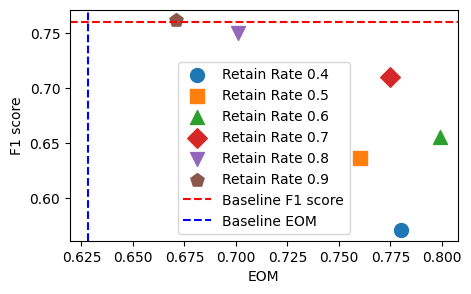

In [140]:
# Scatter plot with different symbols
plt.figure(figsize=(5, 3))

markers = ['o', 's', '^', 'D', 'v', 'p']  # Different markers for each point

for i, rate in enumerate(df['Retain Rate']):
    plt.scatter(df['EOM'][i], df['F1 score'][i], label=f'Retain Rate {rate}', s=100, marker=markers[i])

# Draw lines for baseline model values
plt.axhline(y=0.760, color='r', linestyle='--', label='Baseline F1 score')
plt.axvline(x=0.628, color='b', linestyle='--', label='Baseline EOM')

# Highlight area with higher EOM and F1 score
# plt.fill_betweenx(y=np.linspace(0.75, 0.8, 100), x1=0.628, x2=1, color='yellow', alpha=0.3, label='Highlighted Area')
# Adding labels and legend
plt.xlabel('EOM')
plt.ylabel('F1 score')
plt.legend()

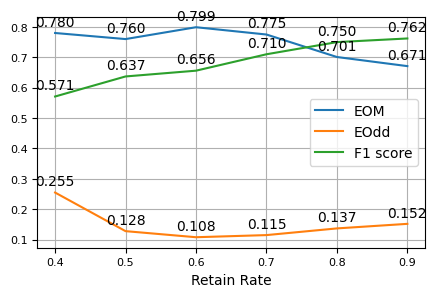

In [130]:
plt.figure(figsize=(5, 3))

for metric in ["EOM", "EOdd", "F1 score"]:
    plt.plot(df['Retain Rate'], df[metric], label=metric)
    for i, txt in enumerate(df[metric]):
        plt.annotate(
            f"{txt:.3f}",
            (df['Retain Rate'][i], df[metric][i]),
            textcoords="offset points",
            xytext=(0, 5),
            ha="center",
            fontsize=10,
        )

plt.xlabel("Retain Rate", fontsize=10)
# plt.ylabel("Metric Values", fontsize=14)
# plt.legend(loc="upper left", bbox_to_anchor=(1, 1), fontsize=12)
plt.legend(loc="center right", fontsize=10)
plt.xticks(df['Retain Rate'], fontsize=8)  # Set discrete values on the x-axis
plt.yticks(fontsize=8)
plt.grid(True)

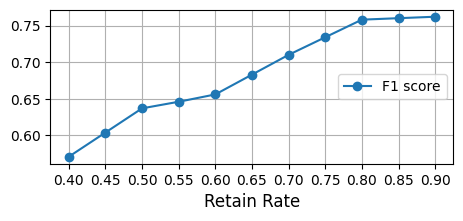

In [163]:
data = {
    'Retain Rate': [0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85,0.9],
    'F1 score': [0.571, 0.604, 0.637, 0.646, 0.656, 0.683, 0.710, 0.734, 0.758, .760, 0.762]
}
# [57.1, 63.7, 65.6, 71.0, 75.0, 76.2]
# [0.571, 0.637, 0.656, 0.710, 0.750, 0.762]
df = pd.DataFrame(data)
plt.figure(figsize=(5.2, 2))

plt.plot(df['Retain Rate'], df["F1 score"], marker='o',label=metric)
    
    

plt.xlabel("Retain Rate", fontsize=12)
# plt.ylabel("Metric Values", fontsize=14)
# plt.legend(loc="upper left", bbox_to_anchor=(1, 1), fontsize=12)
plt.legend(loc="center right", fontsize=10)
plt.xticks(df['Retain Rate'], fontsize=10)  # Set discrete values on the x-axis
plt.yticks(fontsize=10)
plt.grid(True)

## Pruning Rate

In [172]:
data = {
    'Pruning Rate': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
    'EOM': [0.671, 0.675, 0.741, 0.746, 0.740, 0.747, 0.749, 0.696, 0.695],
    'F1 score': [0.764, 0.765, 0.734, 0.732, 0.730, 0.731, 0.723, 0.730, 0.726]
}

df = pd.DataFrame(data)
df

,Pruning Rate,EOM,F1 score
0,0.1,0.671,0.764
1,0.2,0.675,0.765
2,0.3,0.741,0.734
3,0.4,0.746,0.732
4,0.5,0.740,0.730
5,0.6,0.747,0.731
6,0.7,0.749,0.723
7,0.8,0.696,0.730
8,0.9,0.695,0.726


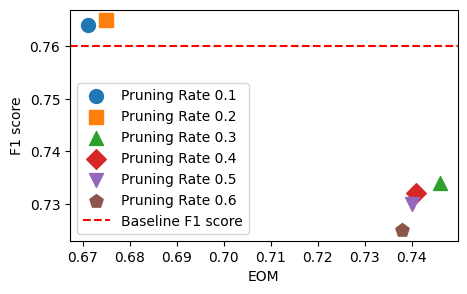

In [154]:
# Scatter plot with different symbols
plt.figure(figsize=(5, 3))

markers = ['o', 's', '^', 'D', 'v', 'p']  # Different markers for each point

for i, rate in enumerate(df['Pruning Rate']):
    plt.scatter(df['EOM'][i], df['F1 score'][i], label=f'Pruning Rate {rate}', s=100, marker=markers[i])

# Draw lines for baseline model values
plt.axhline(y=0.760, color='r', linestyle='--', label='Baseline F1 score')

# Highlight area with higher EOM and F1 score
# plt.fill_betweenx(y=np.linspace(0.75, 0.8, 100), x1=0.628, x2=1, color='yellow', alpha=0.3, label='Highlighted Area')
# Adding labels and legend
plt.xlabel('EOM')
plt.ylabel('F1 score')
plt.legend(loc="lower left", fontsize=10)

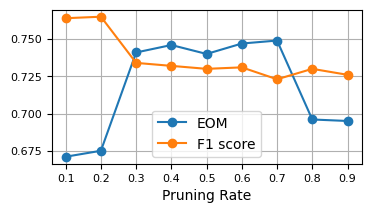

In [176]:
plt.figure(figsize=(4, 2))

for metric in ["EOM", "F1 score"]:
    plt.plot(df['Pruning Rate'], df[metric], marker='o',label=metric)
    # for i, txt in enumerate(df[metric]):
    #     plt.annotate(
    #         f"{txt:.3f}",
    #         (df['Pruning Rate'][i], df[metric][i]),
    #         textcoords="offset points",
    #         xytext=(0, 5),
    #         ha="center",
    #         fontsize=10,
    #     )

plt.xlabel("Pruning Rate", fontsize=10)
# plt.ylabel("Metric Values", fontsize=14)
# plt.legend(loc="upper left", bbox_to_anchor=(1, 1), fontsize=12)
plt.legend(loc="lower center", fontsize=10)
plt.xticks(df['Pruning Rate'], fontsize=8)  # Set discrete values on the x-axis
plt.yticks(fontsize=8)
plt.grid(True)

## Num Batch

In [177]:
data = {
    'Num Batch': [100, 300, 500, 700, 900, 1000],
    'EOM': [0.790, 0.784, 0.790, 0.753, 0.755, 0.706],
    'F1 score': [0.730, 0.737, 0.735, 0.738, 0.738, 0.741]
}

df = pd.DataFrame(data)
df

,Num Batch,EOM,F1 score
0,100,0.790,0.730
1,300,0.784,0.737
2,500,0.790,0.735
3,700,0.753,0.738
4,900,0.755,0.738
5,1000,0.706,0.741


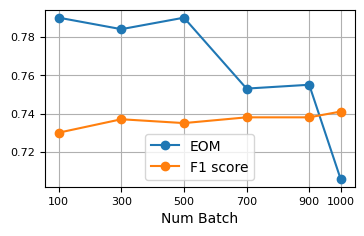

In [184]:
plt.figure(figsize=(4, 2.3))

for metric in ["EOM", "F1 score"]:
    plt.plot(df['Num Batch'], df[metric], marker='o',label=metric)

plt.xlabel("Num Batch", fontsize=10)
plt.legend(loc="lower center", fontsize=10)
plt.xticks(df['Num Batch'], fontsize=8)  # Set discrete values on the x-axis
plt.yticks(fontsize=8)
plt.grid(True)

# FairME

In [67]:
df = pd.read_csv("/home/ali/Repos/Fair-Multi-Exit-Framework/outputs/train_me_resnet18_FITZ_test/Epoch135/df_pred_thresh=0.99.csv")
cal_metrics(df=df)


{'accuracy': 84.3896347174524,
 'acc_per_type': array([82.10702341, 81.14842904, 85.90116279, 88.26619965, 88.34951456,
        83.33333333]),
 'acc_gap': 7.201085527353811,
 'F1_W': 83.79698686438083,
 'F1_per_type_W': array([81.53662703, 80.28385514, 85.41788345, 87.81107499, 88.29674461,
        80.78498686]),
 'F1_W_gap': 8.012889463850755,
 'F1_Mac': 73.41447403109328,
 'F1_per_type_Mac': array([73.10886533, 69.71596197, 75.41725642, 77.25383431, 77.53727754,
        61.79167562]),
 'F1_Mac_gap': 15.745601915814682,
 'PQD': 0.918493207767314,
 'DPM': 0.5814818703985271,
 'EOM': 0.6718756840785239,
 'EOpp0': 0.03545556328320365,
 'EOpp1': 0.11998013005156838,
 'EOdd': 0.12317334672794966,
 'NAR': 0.08486747707313225,
 'NFR_W': 0.09536672089516343,
 'NFR_Mac': 0.2172681871619068,
 'AUC': -1,
 'AUC_per_type': [-1, -1, -1, -1, -1, -1],
 'AUC_Gap': -1,
 'AUC_min': -1,
 'acc_avg_binary': 84.3896347174524,
 'acc_per_type_binary': array([0.82888185, 0.87726358]),
 'PQD_binary': 0.94484926